<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Invalidate cache entry: failed, missing
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1,
  "unsup_weight": 0.5,
  "pseudo_threshold": 0.95,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Creating balanced split...


100%|██████████| 3680/3680 [00:18<00:00, 194.52it/s]


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4539, Train Acc: 90.39%, Val Acc: 98.64%
Epoch [2/3], Loss: 0.0798, Train Acc: 98.78%, Val Acc: 99.18%
Epoch [3/3], Loss: 0.0500, Train Acc: 98.91%, Val Acc: 99.18%
Total elapsed: 36.97s, average per update step: 0.08s
[Trainer] Saved checkpoint to runs/checkpoints/4ea9d8eeef35e59b3f2502ac87c48588.pth
Training result:
{
  "training_losses": [0.45386766321877, 0.07980014367770123, 0.05003601096330151],
  "training_accuracies": [0.9039049235993208, 0.9877758913412563, 0.9891341256366724],
  "validation_accuracies": [0.9863945578231292, 0.9918367346938776, 0.9918367346938776],
  "update_steps": [93, 186, 279],
  "epochs": [1, 2, 3],
  "training_elapsed": 36.96888671900024
}


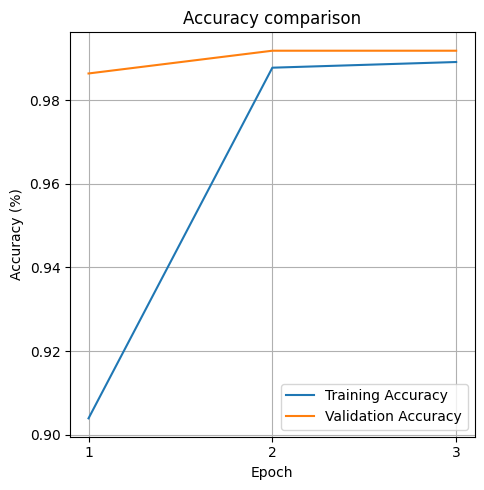

In [2]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams, AdamParams, FinishedAllEpochs
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    binary=True,
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=True) # set to False to enable caching

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

# Test model

In [3]:
from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer

training_params = baseline_params

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_transform(training_params), "binary-category")
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")


Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/4ea9d8eeef35e59b3f2502ac87c48588.pth (epoch 3)
Test size: 3669


/home/jaxner/DD2424-project/training.py:565: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=map_location or self.device)


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 99.29%
